In [115]:

import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [116]:
strategy = tf.distribute.get_strategy() 

In [117]:
from google.colab import drive

drive.mount("/GD", force_remount=True)

imagePatches = glob('/GD/My Drive/BCI/TailoredDataSet/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

Mounted at /GD
/GD/My Drive/BCI/TailoredDataSet/11/0/10253_idx5_x1001_y1001_class0.png
/GD/My Drive/BCI/TailoredDataSet/11/0/10253_idx5_x1051_y551_class0.png
/GD/My Drive/BCI/TailoredDataSet/11/0/10253_idx5_x1001_y651_class0.png
/GD/My Drive/BCI/TailoredDataSet/11/0/10253_idx5_x1051_y1001_class0.png
/GD/My Drive/BCI/TailoredDataSet/11/0/10253_idx5_x1051_y851_class0.png
/GD/My Drive/BCI/TailoredDataSet/11/0/10253_idx5_x1051_y1301_class0.png
/GD/My Drive/BCI/TailoredDataSet/11/0/10253_idx5_x1101_y701_class0.png
/GD/My Drive/BCI/TailoredDataSet/11/0/10253_idx5_x1151_y1201_class0.png
/GD/My Drive/BCI/TailoredDataSet/11/0/10253_idx5_x1001_y1701_class0.png
/GD/My Drive/BCI/TailoredDataSet/11/0/10253_idx5_x1101_y1001_class0.png


In [118]:
class0 = [] 
class1 = [] 

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [119]:
print('calss0 length:', len(class0))
print('calss1 length:', len(class1))

calss0 length: 479
calss1 length: 187


In [120]:
import warnings
warnings.filterwarnings('ignore')

In [121]:

sampled_class0 = random.sample(class0, 187)
sampled_class1 = random.sample(class1, 187)

In [122]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [123]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [124]:
class0_array[1]

[array([[[241, 235, 245],
         [234, 214, 244],
         [225, 198, 229],
         ...,
         [251, 248, 251],
         [251, 247, 249],
         [248, 247, 249]],
 
        [[213, 179, 232],
         [245, 240, 248],
         [221, 191, 215],
         ...,
         [249, 251, 249],
         [250, 248, 251],
         [251, 250, 251]],
 
        [[194, 155, 207],
         [237, 218, 243],
         [235, 220, 241],
         ...,
         [250, 247, 250],
         [247, 243, 248],
         [249, 247, 248]],
 
        ...,
 
        [[247, 243, 247],
         [244, 233, 243],
         [231, 220, 239],
         ...,
         [250, 246, 250],
         [250, 251, 248],
         [242, 237, 247]],
 
        [[249, 248, 251],
         [252, 249, 248],
         [239, 235, 245],
         ...,
         [247, 245, 252],
         [247, 243, 247],
         [254, 248, 248]],
 
        [[249, 250, 250],
         [250, 250, 251],
         [253, 249, 249],
         ...,
         [251, 247, 247],
  

In [125]:
test = cv2.imread('/GD/My Drive/BCI/TailoredDataSet/11/0/10253_idx5_x1001_y1001_class0.png' ,cv2.IMREAD_COLOR)
test.shape

(50, 50, 3)

In [126]:
from keras.preprocessing.image import load_img, img_to_array

def show_img(files):
    plt.figure(figsize= (10,10))
    ind = np.random.randint(0, len(files), 10)
    i=0
    for loc in ind:
        plt.subplot(5,2,i+1)
        sample = load_img(files[loc], target_size=(150,150))
        sample = img_to_array(sample)
        plt.axis("off")
        plt.imshow(sample.astype("uint8"))
        i+=1

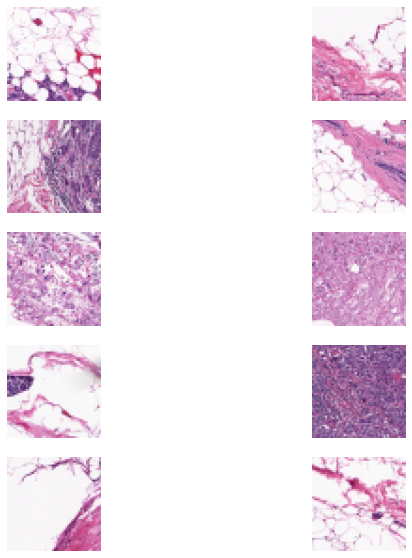

In [127]:
show_img(imagePatches)

In [128]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(42)
random.shuffle(combined_data)

In [129]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [130]:

X = np.array(X).reshape(-1, 50, 50, 3)

In [131]:
X.shape


(374, 50, 50, 3)

In [132]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(280, 50, 50, 3) (94, 50, 50, 3) (280, 2) (94, 2)


In [133]:


def create_model():        
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(50,50,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(2, activation="softmax"))
    adam = Adam(learning_rate=0.0001)
    
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])   

    return model

In [134]:
with strategy.scope():
    model = create_model()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs= 20,
    verbose = 2,
)

Epoch 1/20
9/9 - 5s - loss: 5.9979 - accuracy: 0.7679 - val_loss: 3.1161 - val_accuracy: 0.8617
Epoch 2/20
9/9 - 4s - loss: 1.6029 - accuracy: 0.8786 - val_loss: 1.2906 - val_accuracy: 0.8617
Epoch 3/20
9/9 - 4s - loss: 0.8520 - accuracy: 0.8714 - val_loss: 0.4724 - val_accuracy: 0.8936
Epoch 4/20
9/9 - 4s - loss: 0.3701 - accuracy: 0.9036 - val_loss: 0.5284 - val_accuracy: 0.9043
Epoch 5/20
9/9 - 4s - loss: 0.2504 - accuracy: 0.9500 - val_loss: 0.3468 - val_accuracy: 0.8936
Epoch 6/20
9/9 - 4s - loss: 0.1502 - accuracy: 0.9536 - val_loss: 0.3385 - val_accuracy: 0.9149
Epoch 7/20
9/9 - 4s - loss: 0.0823 - accuracy: 0.9750 - val_loss: 0.3053 - val_accuracy: 0.9255
Epoch 8/20
9/9 - 4s - loss: 0.0498 - accuracy: 0.9893 - val_loss: 0.3427 - val_accuracy: 0.9255
Epoch 9/20
9/9 - 4s - loss: 0.0277 - accuracy: 0.9964 - val_loss: 0.2885 - val_accuracy: 0.9362
Epoch 10/20
9/9 - 4s - loss: 0.0219 - accuracy: 1.0000 - val_loss: 0.3653 - val_accuracy: 0.9255
Epoch 11/20
9/9 - 4s - loss: 0.0125 - a

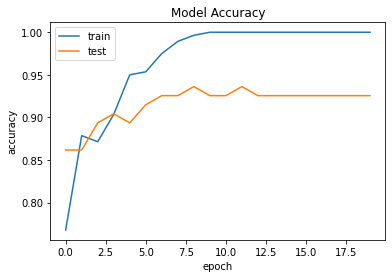

In [135]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()